# 💣 gRNAde Design Notebook

**gRNAde**: **G**eometric Deep Learning pipeline for 3D **RNA** inverse **de**sign. 
This notebook provides the following functionality: 
- Full functional usage of pre-trained gRNAde models for fixed backbone re-design of RNA structures from PDB files, such as riboswitches, aptamers, and ribozymes.
- Single-state and multi-state design, as well as partial design where key nucleotides are fixed.
- Evaluation and visualization tools for designed RNA sequences.

In [13]:
# Import libraries and set up the environment

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("../.env")

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch_geometric

import lovely_tensors as lt
lt.monkey_patch()

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from src.data.featurizer import RNAGraphFeaturizer
from src.models import AutoregressiveMultiGNNv1
from src.trainer import self_consistency_score, self_consistency_score_ribonanza
from src.data.sec_struct_utils import predict_sec_struct
from src.data.data_utils import edit_distance
from src.data.viz_utlils import print_rna_data, draw_struct
from src.constants import PROJECT_PATH, NUM_TO_LETTER

from gRNAde import CHECKPOINT_PATH, set_seed

from tools.ribonanzanet.network import RibonanzaNet

In [2]:
##################
# Design scenario
##################

# Single state or multi state design?
# - 1: single state
# - 2, 3, 5: multi state (number of states)
max_num_conformers = 1

# Model checkpoint split:
# - options include 'all', 'das', 'multi'
# - unless benchmarking, we recommend using 'all' for general usage
split = 'all'

# random seed for reproducibility
seed = 0

# Default model hyperparameters (do not change)
VERSION = 0.2
RADIUS = 0.0
TOP_K = 32
NUM_RBF = 32
NUM_POSENC = 32
NOISE_SCALE = 0.1
NODE_IN_DIM = (15, 4)
NODE_H_DIM = (128, 16)
EDGE_IN_DIM = (131, 3)
EDGE_H_DIM = (64, 4)
NUM_LAYERS = 4
DROP_RATE = 0.5
OUT_DIM = 4
DEFAULT_N_SAMPLES = 16
DEFAULT_TEMPERATURE = 0.1

In [3]:
#########################################
# Initialise gRNAde model and featurizer
#########################################

# Set random seed
set_seed(seed)

# Set device (GPU/CPU)
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data featurizer
print(f"Creating RNA graph featurizer for max_num_conformers={max_num_conformers}")
featurizer = RNAGraphFeaturizer(
    split = "test",  # set to 'train' to use noise augmentation
    radius = RADIUS,
    top_k = TOP_K,
    num_rbf = NUM_RBF,
    num_posenc = NUM_POSENC,
    max_num_conformers = max_num_conformers,
    noise_scale = NOISE_SCALE
)
# nucleotide mapping: {'A': 0, 'G': 1, 'C': 2, 'U': 3}

# Initialise model
print(f"Initialising GNN encoder-decoder model")
model = AutoregressiveMultiGNNv1(
    node_in_dim = NODE_IN_DIM,
    node_h_dim = NODE_H_DIM, 
    edge_in_dim = EDGE_IN_DIM,
    edge_h_dim = EDGE_H_DIM, 
    num_layers = NUM_LAYERS,
    drop_rate = DROP_RATE,
    out_dim = OUT_DIM
)
# Load model checkpoint
model_path = CHECKPOINT_PATH[split][max_num_conformers]
print(f"Loading gRNAde checkpoint: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# Transfer model to device in eval mode
model = model.to(device)
model.eval()

# Initialise RibonanzaNet for self-consistency score
ribonanza_net = RibonanzaNet(
    '/home/ckj24/rna-inverse-folding/tools/ribonanzanet/config.yaml',
    '/home/ckj24/rna-inverse-folding/tools/ribonanzanet/ribonanzanet.pt',
    device
)
# Transfer model to device in eval mode
ribonanza_net = ribonanza_net.to(device)
ribonanza_net.eval()
print()

Using device: cuda:0
Creating RNA graph featurizer for max_num_conformers=1
Initialising GNN encoder-decoder model
Loading gRNAde checkpoint: /home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_1state_all.h5
Loading RibonanzaNet checkpoint: /home/ckj24/rna-inverse-folding/tools/ribonanzanet/ribonanzanet.pt



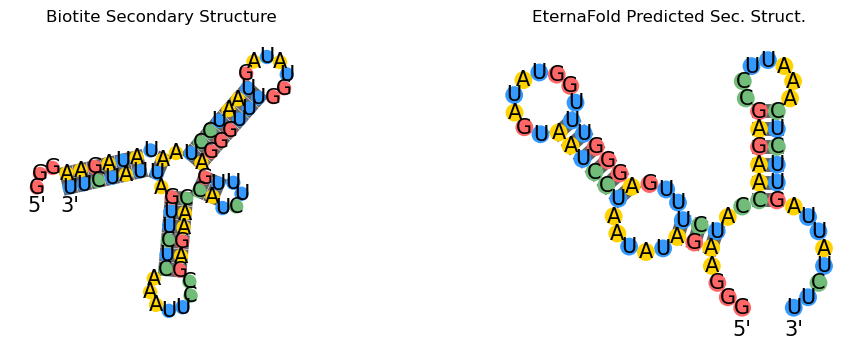

sequence:
	GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
coords_list:
	tensor[68, 3, 3] n=612 (2.4Kb) x∈[-29.815, 28.403] μ=0.052 σ=11.331
sec_struct_list:
	...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
eterna_sec_struct_list:
	....(((.....((((((.........))))))...)))..((((((.......))))))........
ribonanza_chem_mod:
	tensor[68, 2] n=136 x∈[5.461e-05, 1.005] μ=0.271 σ=0.276
Featurized PyG Data object:
	 Data(edge_index=[2, 2558], seq=[68], node_s=[68, 1, 15], node_v=[68, 1, 4, 3], edge_s=[2558, 1, 131], edge_v=[2558, 1, 3, 3], mask_confs=[68, 1], mask_coords=[68])


In [4]:
##############################
# Load PDB file and featurize
##############################

pdb_filepath = os.path.join(PROJECT_PATH, "tutorial/demo_data/adenine_riboswitch/5E54_1_B.pdb")

featurized_data, raw_data = featurizer.featurize_from_pdb_file(pdb_filepath)
# for multi-state design, use: featurize_from_pdb_filelist

# Add predicted secondary structure using EternaFold
raw_data['eterna_sec_struct_list'] = predict_sec_struct(raw_data['sequence'])

# Add predicted chemical modifications using RibonanzaNet
raw_data['ribonanza_chem_mod'] = ribonanza_net.predict(raw_data['sequence'])

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
plt.title('Biotite Secondary Structure')
draw_struct(raw_data['sequence'], raw_data['sec_struct_list'][0], ax=ax1)
ax2 = plt.subplot(1, 2, 2)
plt.title('EternaFold Predicted Sec. Struct.')
draw_struct(raw_data['sequence'], raw_data['eterna_sec_struct_list'][0], ax=ax2)
plt.show()

print_rna_data(raw_data)

print("Featurized PyG Data object:\n\t", featurized_data)

In [11]:
###############################
# Partial sequence constraints
###############################

print("Raw sequence:        ", raw_data['sequence'])
print("Featurized sequence: ", "".join([featurizer.num_to_letter[num] for num in featurized_data.seq.cpu().numpy()]))
# Sometimes, the first nucleotide is not included in the featurized sequence due to missing Phosphate coordinates.
# In this case, we can add the first nucleotide manually back to designed sequences with very minor post processing.

# Set partial sequence constraints (all _'s are designable positions)
partial_seq = "".join(["_"]*len(featurized_data.seq))
print(f"Partial sequence:    ", partial_seq)

# Add sequence constraints to partial_seq here:
# For instance, we may want to fix key base pairs based on the secondary structure
# sequence:    GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
# sec.struct.: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
partial_seq = '__________________U_______U______GU____AC_____G_______C_____________'
print(f"Partial sequence:    ", partial_seq)
print(f"Edit distance after fixing positions: {edit_distance(raw_data['sequence'], partial_seq)}")

# transfer data to device
featurized_data = featurized_data.to(device)

# create logit bias matrix if partial sequence is provided
if partial_seq is not None:
    # convert partial sequence to tensor
    _partial_seq = []
    for residue in partial_seq:
        if residue in featurizer.letter_to_num.keys():
            # fixed nucleotide
            _partial_seq.append(featurizer.letter_to_num[residue])
        else:
            # designable position
            _partial_seq.append(len(featurizer.letter_to_num.keys()))
    _partial_seq = torch.as_tensor(_partial_seq, device=device, dtype=torch.long)
    # convert to one-hot and create bias matrix used during sampling
    logit_bias = F.one_hot(_partial_seq, num_classes=model.out_dim+1).float()
    
    #########################################################
    # Create final logit_bias matrix for masked sampling
    # - you can manually adjust the bias for more customised 
    #   designs and constraints. 
    #########################################################
    logit_bias = logit_bias[:, :-1] * 100.0
else:
    logit_bias = None

Raw sequence:         GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Featurized sequence:  GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Partial sequence:     ____________________________________________________________________
Partial sequence:     __________________U_______U______GU____AC_____G_______C_____________
Edit distance after fixing positions: 60


In [12]:
##############################
# Sequence design and scoring
##############################

# Number of designed samples
n_samples = 8

# Sampling temperature
# - Low temperature (eg. 0.1) : more greedy sampling, generally higher sequence recovery
# - High temperature (eg. 1.0) : more diverse sampling, generally lower sequence recovery
temperature = 0.5

# sample n_samples from model for single data point: n_samples x seq_len
samples, logits = model.sample(
    featurized_data, n_samples, temperature, logit_bias, return_logits=True)

# perplexity per sample: n_samples x 1
n_nodes = logits.shape[1]
perplexity = torch.exp(F.cross_entropy(
    logits.view(n_samples * n_nodes, model.out_dim), 
    samples.view(n_samples * n_nodes).long(), 
    reduction="none"
).view(n_samples, n_nodes).mean(dim=1)).cpu().numpy()

# sequence recovery per sample: n_samples x 1
recovery = samples.eq(featurized_data.seq).float().mean(dim=1).cpu().numpy()

# global self consistency score (EternaFold) per sample: n_samples x 1
sc_score, pred_sec_structs = self_consistency_score(
    samples.cpu().numpy(), 
    raw_data['sec_struct_list'], 
    featurized_data.mask_coords.cpu().numpy(), # np.array([True] * len(raw_data['sequence']))
    return_sec_structs = True
)

# global self consistency score (RibonanzaNet) per sample: n_samples x 1
sc_score_ribonanza, pred_chem_mods = self_consistency_score_ribonanza(
    samples.cpu().numpy(), 
    raw_data["ribonanza_chem_mod"].unsqueeze(0).cpu().numpy(), 
    ribonanza_net,
    return_chem_mods = True
)

>sample=0, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3266 recovery=0.7794 sc_score=0.8359 sc_score_ribo=0.1462
GAGCGGACAUAAUCGUCAUGAUAUGGUUGGCGAGUAUCAACCGAGAGCCUUAAACUCUCG
AUUGUCCG

Sample 0
    Designed sequence:    GAGCGGACAUAAUCGUCAUGAUAUGGUUGGCGAGUAUCAACCGAGAGCCUUAAACUCUCGAUUGUCCG
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3266
    Recovery: 0.7794
    Edit distance: 15

    Predicted secondary structure:   ...((((((((.((((((.........)))))).))...(.((((((.......)))))).)))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.8359
    SC Score (RibonanzaNet): 0.1462


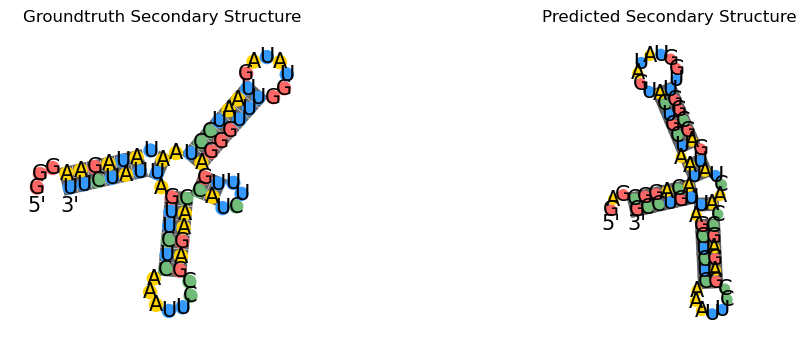

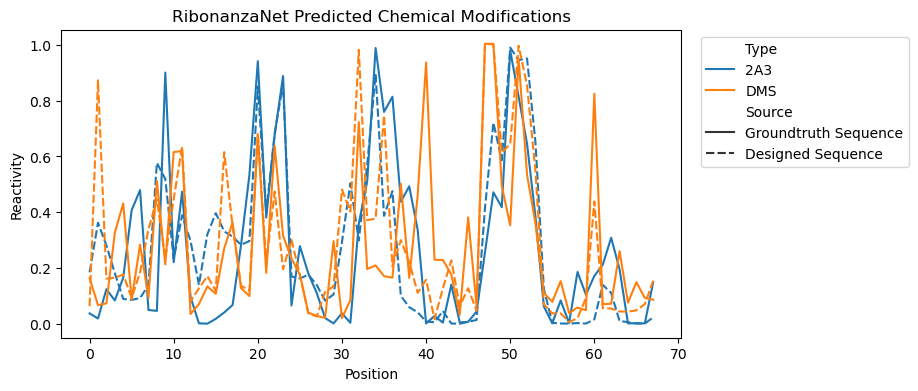

______________________________________________________________________________________________________________________________________________________
>sample=1, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3025 recovery=0.7500 sc_score=0.8794 sc_score_ribo=0.1500
GGGGGCAUACAACCGUCAUGAUAUGGUUGGCGGGUAUUUACCGAGAGCCUUAAACUCUCG
AUUAUGCC

Sample 1
    Designed sequence:    GGGGGCAUACAACCGUCAUGAUAUGGUUGGCGGGUAUUUACCGAGAGCCUUAAACUCUCGAUUAUGCC
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3025
    Recovery: 0.7500
    Edit distance: 17

    Predicted secondary structure:   ...(((((((..((((((.........))))))).......((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.8794
    SC Score (RibonanzaNet): 0.1500


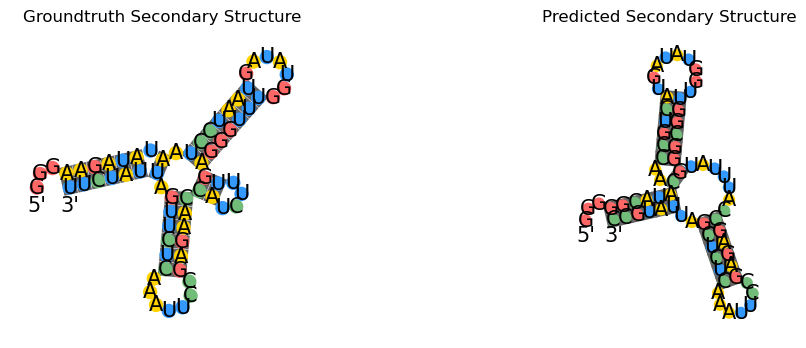

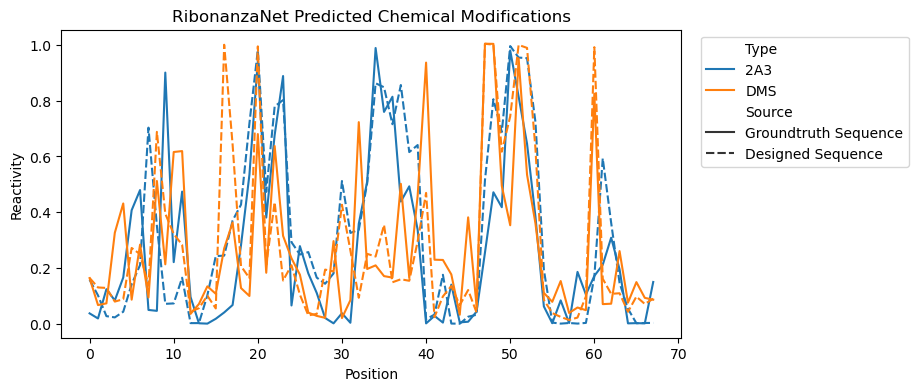

______________________________________________________________________________________________________________________________________________________
>sample=2, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3292 recovery=0.7353 sc_score=0.8794 sc_score_ribo=0.1676
GACCGGAUACAACCGUCAUGAUAUGGUUGGCGGGUAUACACCGAGAGCCUUAAACUCUCG
AUUAUCCG

Sample 2
    Designed sequence:    GACCGGAUACAACCGUCAUGAUAUGGUUGGCGGGUAUACACCGAGAGCCUUAAACUCUCGAUUAUCCG
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3292
    Recovery: 0.7353
    Edit distance: 18

    Predicted secondary structure:   ...(((((((..((((((.........))))))).......((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.8794
    SC Score (RibonanzaNet): 0.1676


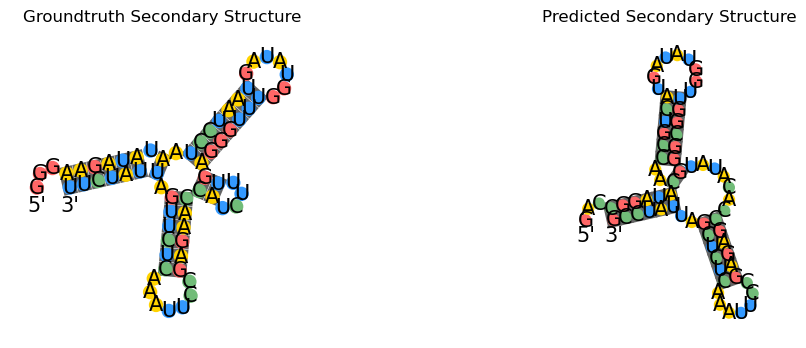

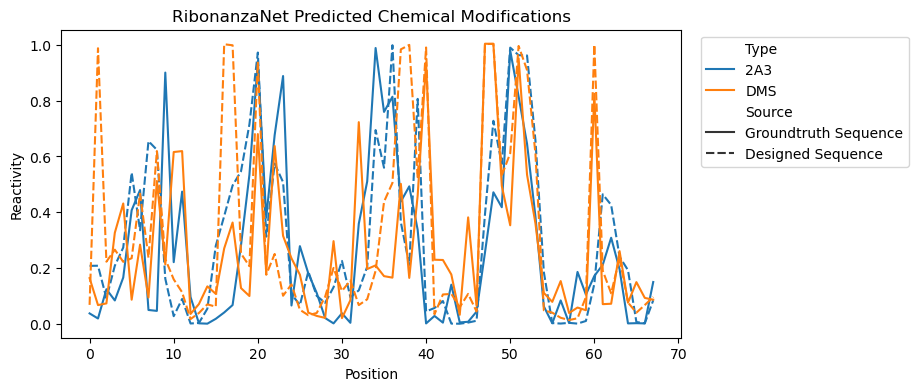

______________________________________________________________________________________________________________________________________________________
>sample=3, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3161 recovery=0.7206 sc_score=0.8794 sc_score_ribo=0.1351
GGGCGCAUGCAAACCUCAUGAUAUGGUUGGGGUGUAUAUACCAGAAGCCUUAAACUUCUG
AUCAUGCG

Sample 3
    Designed sequence:    GGGCGCAUGCAAACCUCAUGAUAUGGUUGGGGUGUAUAUACCAGAAGCCUUAAACUUCUGAUCAUGCG
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3161
    Recovery: 0.7206
    Edit distance: 19

    Predicted secondary structure:   ...(((((((..((((((.........))))))).......((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.8794
    SC Score (RibonanzaNet): 0.1351


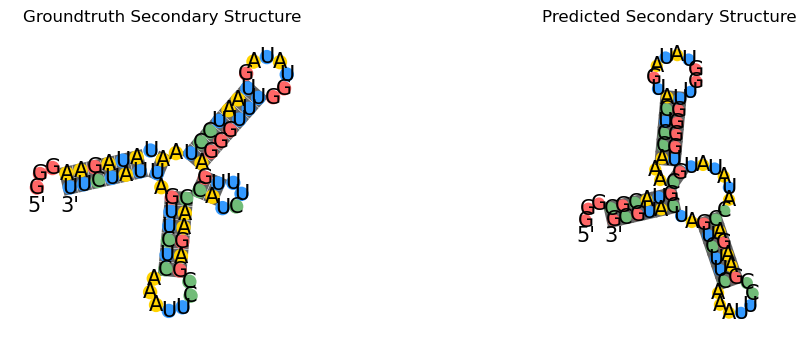

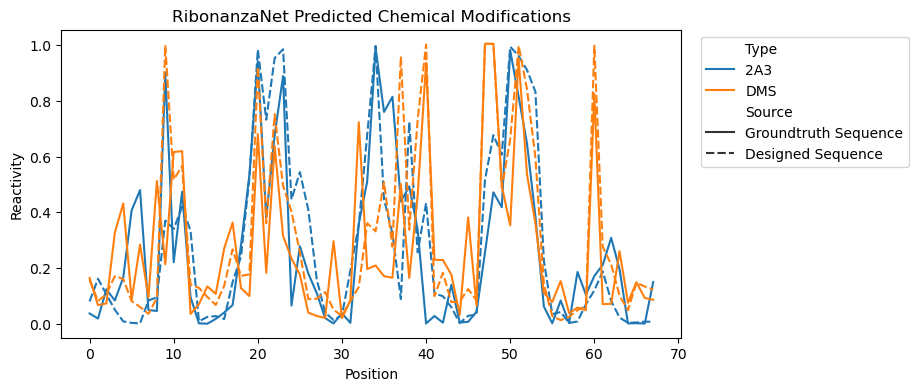

______________________________________________________________________________________________________________________________________________________
>sample=4, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3330 recovery=0.7500 sc_score=0.7313 sc_score_ribo=0.1488
GAGCGCAUCUAAUCGUCAUGAUAUGGUUGGCGAGUAUCAACCGAGAGCCUUAAACUCUCG
AUGAUGCG

Sample 4
    Designed sequence:    GAGCGCAUCUAAUCGUCAUGAUAUGGUUGGCGAGUAUCAACCGAGAGCCUUAAACUCUCGAUGAUGCG
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3330
    Recovery: 0.7500
    Edit distance: 17

    Predicted secondary structure:   ...(((......((((((.........))))))..((((..((((((.......)))))).)))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.7313
    SC Score (RibonanzaNet): 0.1488


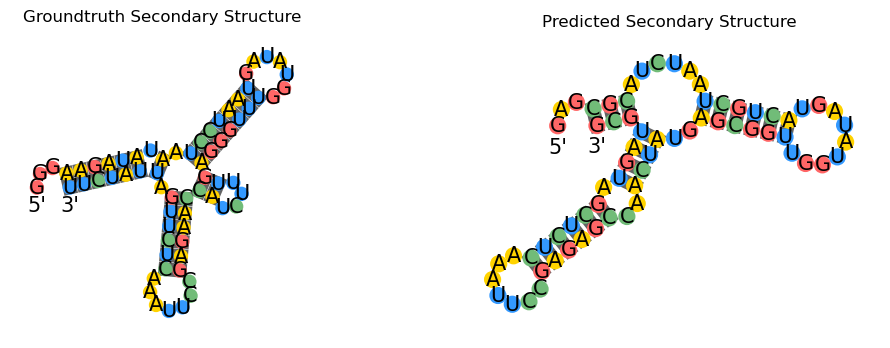

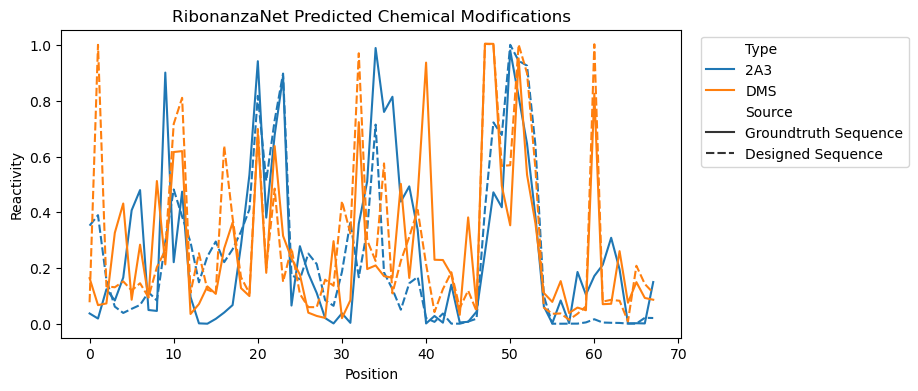

______________________________________________________________________________________________________________________________________________________
>sample=5, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3859 recovery=0.7647 sc_score=0.8359 sc_score_ribo=0.1284
GGUUGCAUAUAACGAUCAUGAUAUGGUUGGUCGGUUUAUACCAAGAGCCUUAAACUCUUG
AUUAUGCA

Sample 5
    Designed sequence:    GGUUGCAUAUAACGAUCAUGAUAUGGUUGGUCGGUUUAUACCAAGAGCCUUAAACUCUUGAUUAUGCA
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3859
    Recovery: 0.7647
    Edit distance: 16

    Predicted secondary structure:   ...(((((((((((((((.........))))))..)))...((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.8359
    SC Score (RibonanzaNet): 0.1284


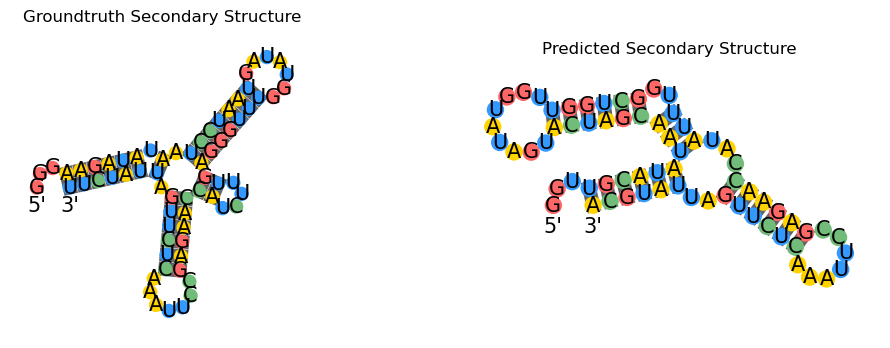

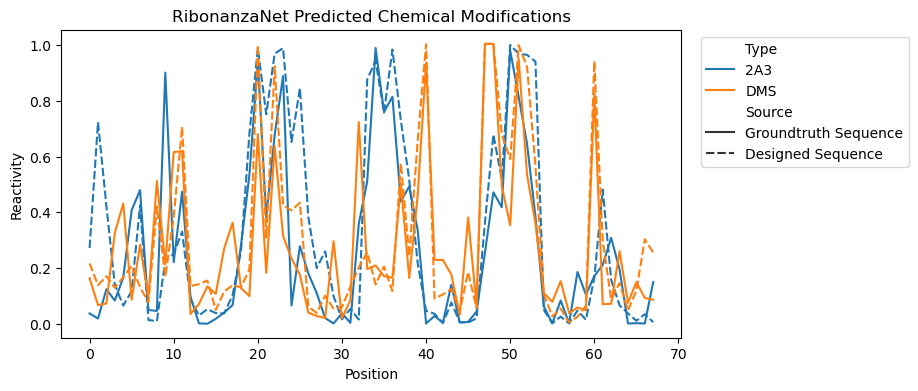

______________________________________________________________________________________________________________________________________________________
>sample=6, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3418 recovery=0.6324 sc_score=0.5072 sc_score_ribo=0.1689
GGUGGGGACCAACCGUCAUGAUAUGGUUGGCGGGUAUACACCAGAAGCCUUAAACUUCUG
AUGUCCCC

Sample 6
    Designed sequence:    GGUGGGGACCAACCGUCAUGAUAUGGUUGGCGGGUAUACACCAGAAGCCUUAAACUUCUGAUGUCCCC
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3418
    Recovery: 0.6324
    Edit distance: 24

    Predicted secondary structure:   ...(((((((((((((......))))))))........((.((((((.......)))))).)))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.5072
    SC Score (RibonanzaNet): 0.1689


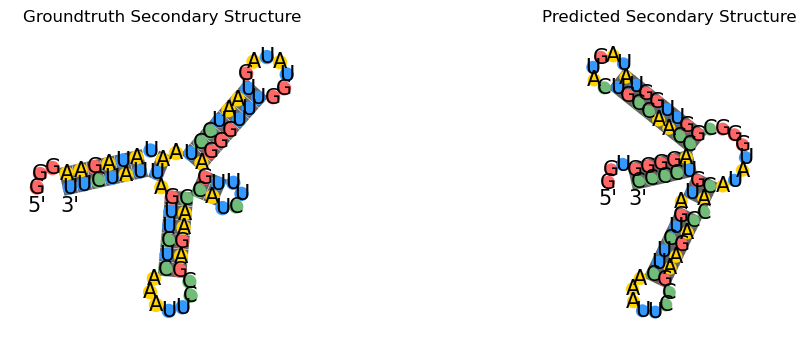

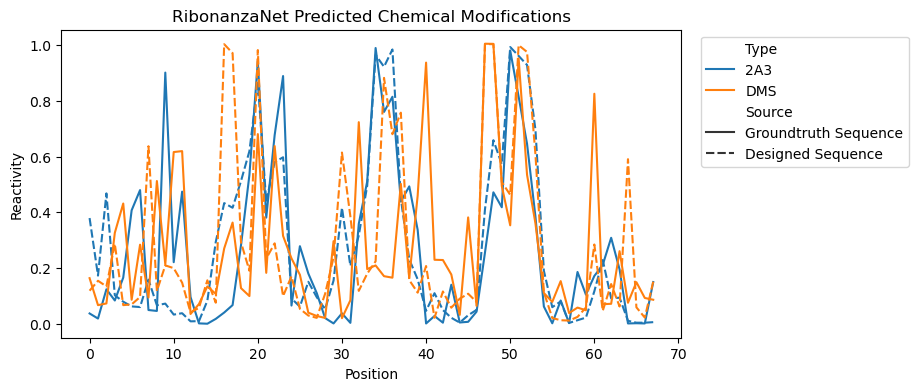

______________________________________________________________________________________________________________________________________________________
>sample=7, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3443 recovery=0.7647 sc_score=0.7705 sc_score_ribo=0.1515
GGUGGCAAAUAAUCGUCAUGAUAUGGUUGGCGAGUAUAAACCAAGAGCCUUAAACUCUUG
AUUUUGCC

Sample 7
    Designed sequence:    GGUGGCAAAUAAUCGUCAUGAUAUGGUUGGCGAGUAUAAACCAAGAGCCUUAAACUCUUGAUUUUGCC
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3443
    Recovery: 0.7647
    Edit distance: 16

    Predicted secondary structure:   ...((((((((.((((((.........)))))).))).((.((((((.......)))))).)))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (EternaFold): 0.7705
    SC Score (RibonanzaNet): 0.1515


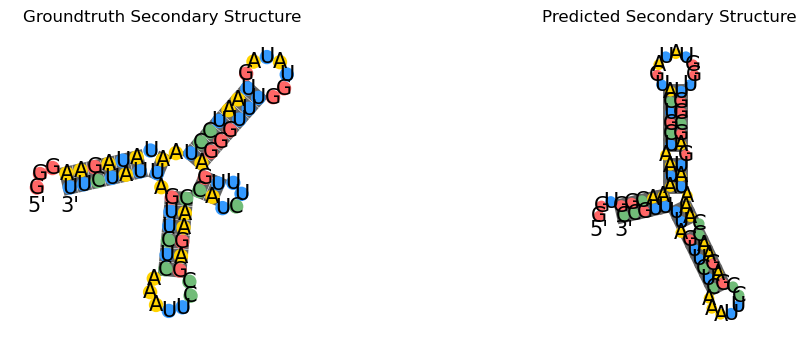

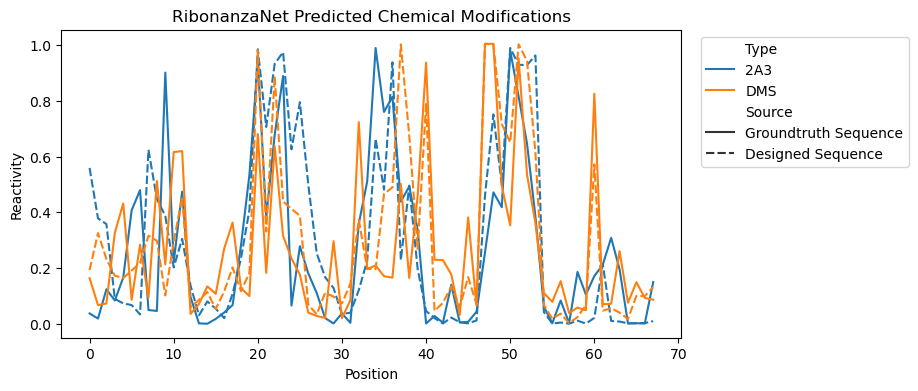

______________________________________________________________________________________________________________________________________________________


In [14]:
####################################
# Visualise and select best designs
####################################

# collate designed sequences in fasta format
sequences = [
    # first record: input sequence and model metadata
    SeqRecord(
        Seq(raw_data["sequence"]),
        id=f"input_sequence,",
        description=f"checkpoint={model_path}, seed={seed}"
    )
]
# remaining records: designed sequences and metrics
for idx, zipped in enumerate(zip(
    samples.cpu().numpy(),
    perplexity,
    recovery,
    sc_score,
    pred_sec_structs,
    sc_score_ribonanza,
    pred_chem_mods
)):
    seq, perp, rec, sc, pred_ss, sc_ribo, pred_cm = zipped
    seq = "".join([NUM_TO_LETTER[num] for num in seq])
    sequences.append(SeqRecord(
        Seq(seq), 
        id=f"sample={idx},",
        description=f"{os.path.split(model_path)[-1]} seed={seed} temperature={temperature} perplexity={perp:.4f} recovery={rec:.4f} sc_score={sc:.4f} sc_score_ribo={sc_ribo:.4f}"
    ))

    print(sequences[-1].format('fasta'))
    print(f"Sample {idx}")
    print(f"    Designed sequence:    {seq}")
    print(f"    Groundtruth sequence: {raw_data['sequence']}")
    print(f"    Perplexity: {perp:.4f}")
    print(f"    Recovery: {rec:.4f}")
    print(f"    Edit distance: {edit_distance(seq, raw_data['sequence'])}")
    print()
    print(f"    Predicted secondary structure:   {pred_ss[0]}")
    print(f"    Groundtruth secondary structure: {raw_data['sec_struct_list'][0]}")
    print(f"    SC Score (EternaFold): {sc:.4f}")
    print(f"    SC Score (RibonanzaNet): {sc_ribo:.4f}")
    
    # create two subplots for predicted and groundtruth secondary structure
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    plt.title('Groundtruth Secondary Structure')
    draw_struct(raw_data['sequence'], raw_data['sec_struct_list'][0], ax=ax1)
    ax2 = plt.subplot(1, 2, 2)
    plt.title('Predicted Secondary Structure')
    draw_struct(seq, pred_ss[0], ax=ax2)
    plt.show()

    # plot predicted and groundtruth chemical modification
    plt.figure(figsize=(8, 4))
    plt.title('RibonanzaNet Predicted Chemical Modifications')
    df = pd.DataFrame({
        "Position": np.concatenate([np.arange(len(raw_data['sequence']))]*4),
        "Reactivity": np.concatenate([
            raw_data["ribonanza_chem_mod"][:,0].cpu().numpy(), 
            raw_data["ribonanza_chem_mod"][:,1].cpu().numpy(), 
            pred_cm[:,0].cpu().numpy(),
            pred_cm[:,1].cpu().numpy(),
        ]),
        "Source": np.concatenate([
            ["Groundtruth Sequence"]*len(raw_data["ribonanza_chem_mod"])*2, 
            ["Designed Sequence"]*len(pred_cm)*2,
        ]),
        "Type": np.concatenate([
            ["2A3"]*len(raw_data["ribonanza_chem_mod"]),
            ["DMS"]*len(raw_data["ribonanza_chem_mod"]), 
            ["2A3"]*len(pred_cm),
            ["DMS"]*len(pred_cm),
        ])
    })
    sns.lineplot(data=df, x="Position", y="Reactivity", hue="Type", style="Source")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.show()
    print("_"*150)

# write sequences to output filepath
# output_filepath = ""
# SeqIO.write(sequences, output_filepath, "fasta")